# Figure 2 a-d

In [2]:
library(openxlsx)
library(ggplot2)
library(stringr)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(clusterProfiler)
library(enrichplot)
library(GOplot)
library(DOSE)
library(ggnewscale)
library(topGO)
library(circlize)
library(ComplexHeatmap)
library(dplyr)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, sort, table, tapply,
    unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cit

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(info$Gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
“4.66% of input gene IDs are fail to map...”
'select()' returned many:many mapping between keys and columns

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

Warning message in dplyr::left_join(., geneIDselect, by = "SYMBOL"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 6 of `x` matches multiple rows in `y`.
ℹ Row 175 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stat

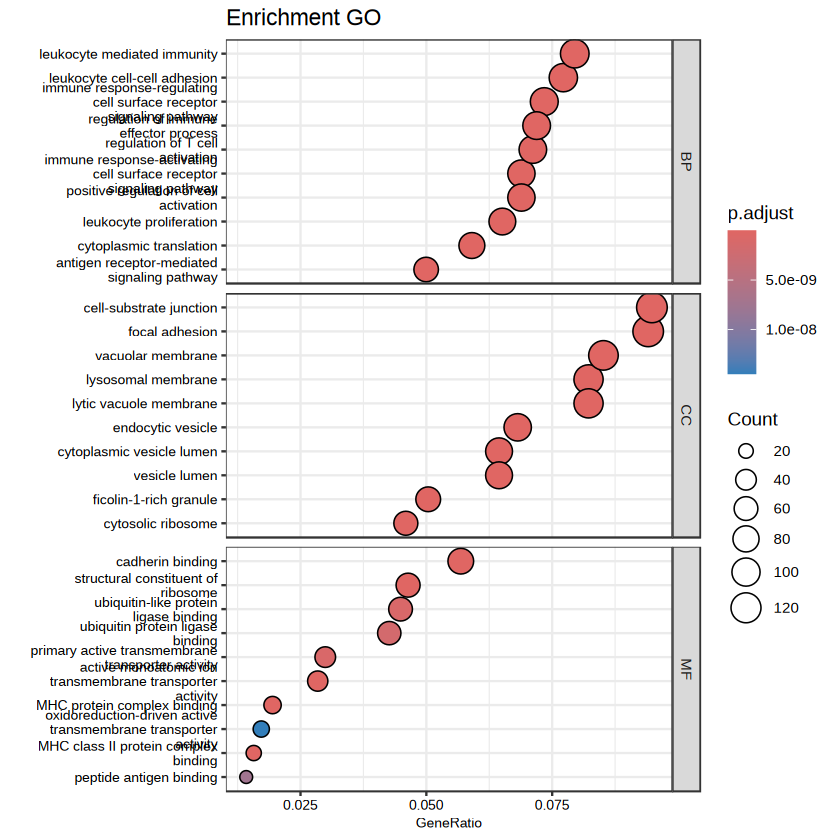

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_point()`).”


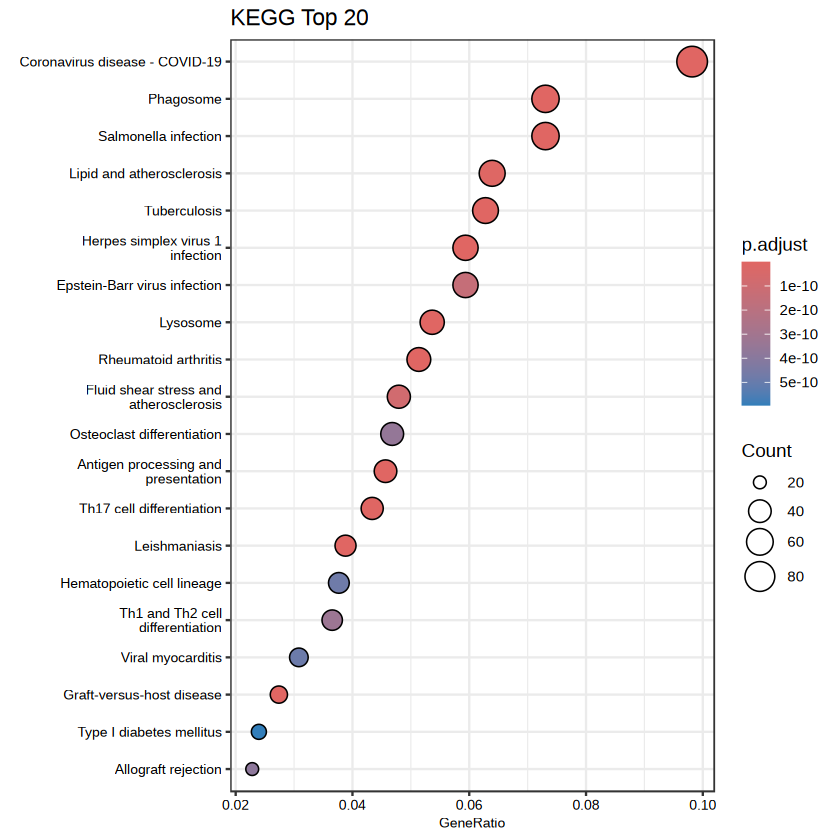

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_point()`).”


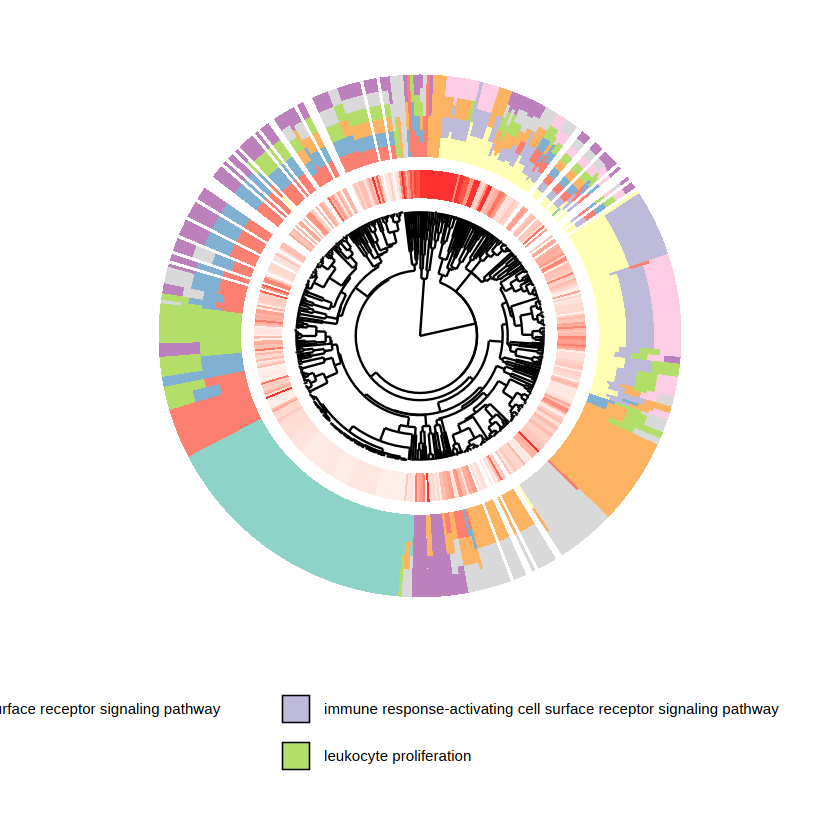

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range
(`geom_point()`).”


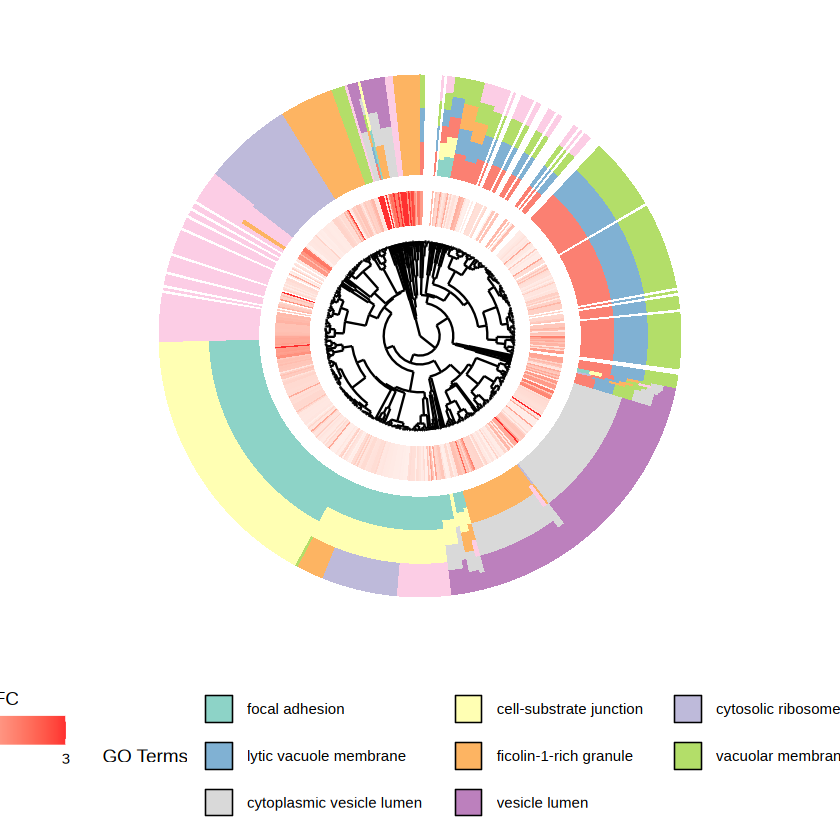

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`).”


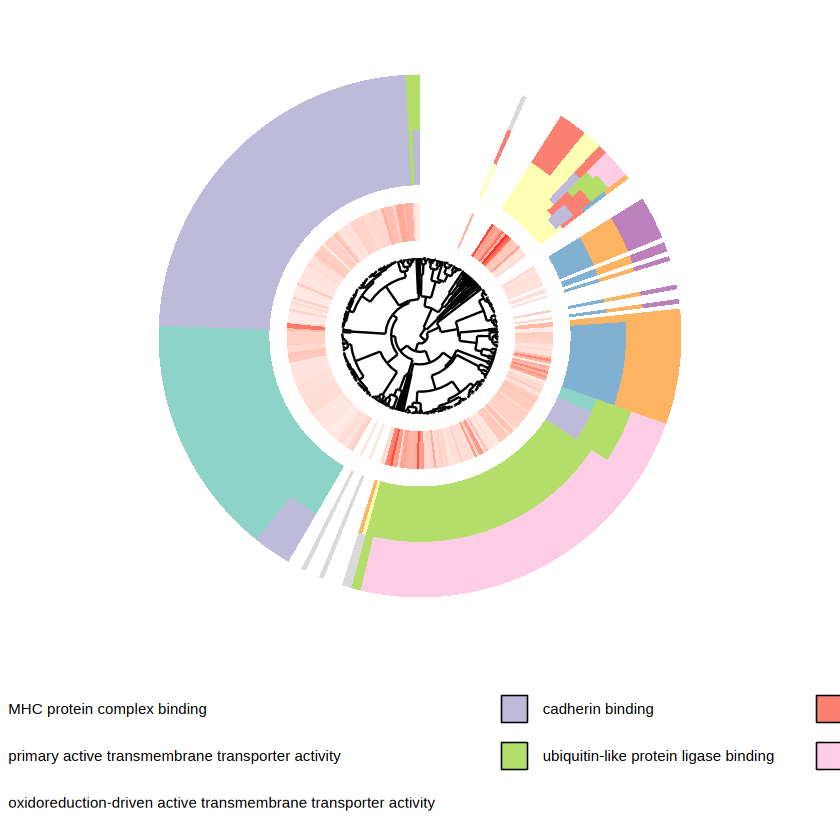

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


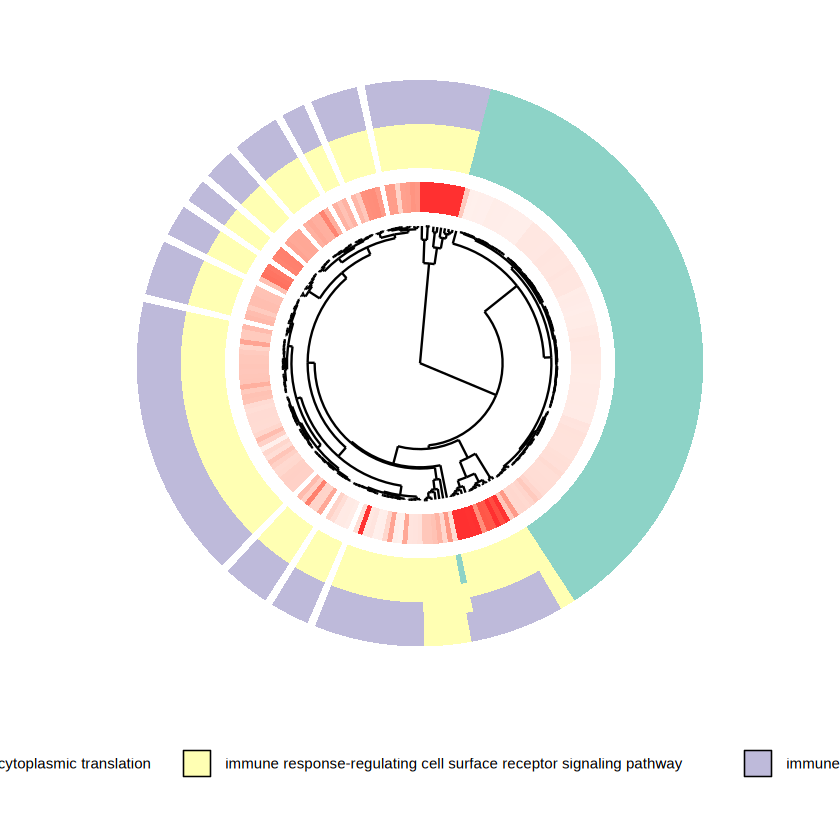

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_point()`).”


agg_record_970044312 
                   2

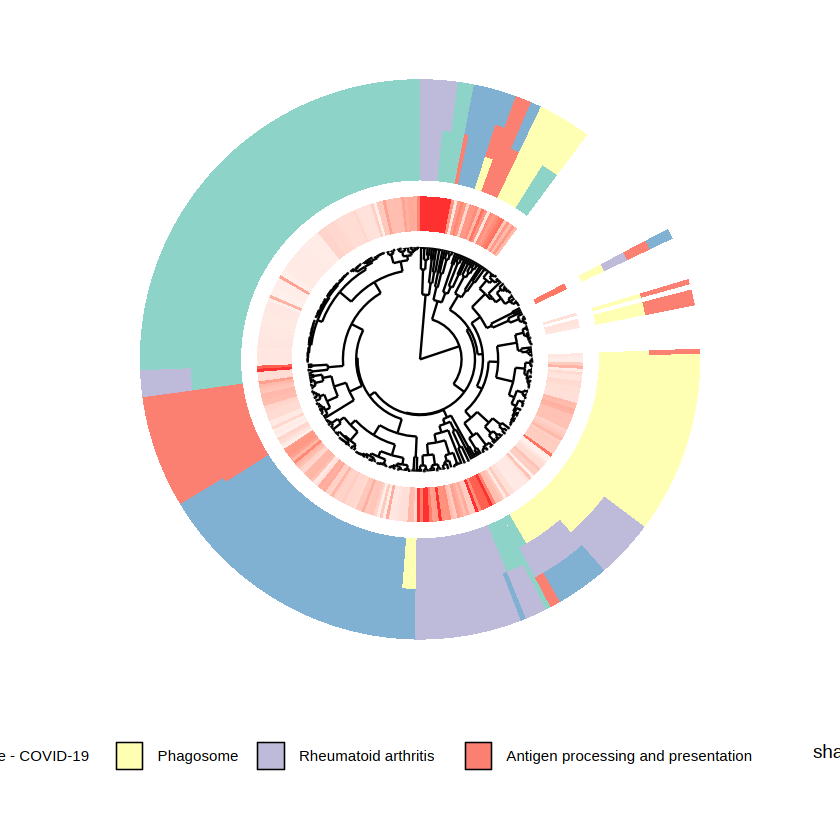

In [3]:
# Load gene list from Excel
info <- read.xlsx("/public/hubCache/workshop/sunhy/projects/song_project/revise_rscript/gene_list.xlsx",
                  rowNames = FALSE, colNames = TRUE)

# Convert gene symbols to Entrez IDs
gene <- bitr(info$Gene,
             fromType = "SYMBOL",
             toType = "ENTREZID",
             OrgDb = org.Hs.eg.db)

# Retrieve additional annotations using AnnotationDbi::select
geneIDselect <- AnnotationDbi::select(
  org.Hs.eg.db,
  keys = info$Gene,
  columns = c("ENTREZID", "ENSEMBL", "GENENAME"),
  keytype = "SYMBOL"
)

GO_database <- org.Hs.eg.db
KEGG_database <- "hsa"

# Perform GO enrichment analysis
GO <- enrichGO(
  gene = geneIDselect$ENTREZID,
  OrgDb = GO_database,
  keyType = "ENTREZID",
  ont = "ALL",
  pvalueCutoff = 0.05,
  qvalueCutoff = 0.05,
  readable = TRUE
)

# Perform KEGG enrichment analysis
KEGG <- enrichKEGG(
  gene = gene$ENTREZID,
  organism = KEGG_database,
  pvalueCutoff = 0.05,
  qvalueCutoff = 0.05
)

# Convert KEGG results to readable gene names
KEGG2 <- setReadable(KEGG, OrgDb = org.Hs.eg.db, keyType = "ENTREZID")


# Merge info with ENTREZID
info_merge <- info %>%
  dplyr::rename(SYMBOL = Gene) %>%         # Ensure column name matches
  dplyr::left_join(geneIDselect, by = "SYMBOL") %>%  # Map SYMBOL to ENTREZID
  dplyr::filter(!is.na(ENTREZID)) %>%     # Remove genes without ENTREZID
  dplyr::group_by(ENTREZID) %>%
  dplyr::summarise(Log2FoldChange = max(as.numeric(Log2FoldChange)))

# Prepare GSEA input
GSEA_input <- info_merge$Log2FoldChange
names(GSEA_input) <- info_merge$ENTREZID
GSEA_input <- sort(GSEA_input, decreasing = TRUE)

# Run GSEA for KEGG pathways
GSEA_KEGG <- gseKEGG(GSEA_input, organism = KEGG_database, pvalueCutoff = 0.05)

# GO enrichment plots
b1 <- barplot(GO, split = "ONTOLOGY", font.size = 8, title = "Enrichment GO") +
      facet_grid(ONTOLOGY ~ ., scale = "free")
dotplot(GO, split = "ONTOLOGY", font.size = 8, title = "Enrichment GO") +
      facet_grid(ONTOLOGY ~ ., scale = "free")

# KEGG enrichment plots
b2 <- barplot(KEGG, showCategory = 20, title = "KEGG Top 20", font.size = 8)
dotplot(KEGG, showCategory = 20, title = "KEGG Top 20", font.size = 8)

# Save plots
ggsave("GO.ALL.pdf", b1, width = 7, height = 7)
ggsave("KEGG.20.pdf", b2, width = 7, height = 7)



genedata <- data.frame(
  ID = info$Gene,
  logFC = as.numeric(info$Log2FoldChange),
  stringsAsFactors = FALSE
)

GOplotIn_BP <- GO[GO$ONTOLOGY == "BP", ][1:10, ]
GOplotIn_CC <- GO[GO$ONTOLOGY == "CC", ][1:10, ]
GOplotIn_MF <- GO[GO$ONTOLOGY == "MF", ][1:10, ]

GOplotIn_BP$Genes <- str_replace_all(as.character(GOplotIn_BP$geneID), "/", ",")
GOplotIn_CC$Genes <- str_replace_all(as.character(GOplotIn_CC$geneID), "/", ",")
GOplotIn_MF$Genes <- str_replace_all(as.character(GOplotIn_MF$geneID), "/", ",")

GOplotIn_BP <- data.frame(
  ID = GOplotIn_BP$ID,
  Term = GOplotIn_BP$Description,
  adj_pval = GOplotIn_BP$p.adjust,
  Genes = GOplotIn_BP$Genes,
  Category = "BP",
  stringsAsFactors = FALSE
)
GOplotIn_CC <- data.frame(
  ID = GOplotIn_CC$ID,
  Term = GOplotIn_CC$Description,
  adj_pval = GOplotIn_CC$p.adjust,
  Genes = GOplotIn_CC$Genes,
  Category = "CC",
  stringsAsFactors = FALSE
)
GOplotIn_MF <- data.frame(
  ID = GOplotIn_MF$ID,
  Term = GOplotIn_MF$Description,
  adj_pval = GOplotIn_MF$p.adjust,
  Genes = GOplotIn_MF$Genes,
  Category = "MF",
  stringsAsFactors = FALSE
)

genedata$ID <- toupper(genedata$ID)
GOplotIn_BP$Genes <- toupper(GOplotIn_BP$Genes)
GOplotIn_CC$Genes <- toupper(GOplotIn_CC$Genes)
GOplotIn_MF$Genes <- toupper(GOplotIn_MF$Genes)

filter_GO <- function(GOtab, genedata) {
  keep <- sapply(strsplit(GOtab$Genes, ","), function(x) any(x %in% genedata$ID))
  GOtab[keep, ]
}

GOplotIn_BP <- filter_GO(GOplotIn_BP, genedata)
GOplotIn_CC <- filter_GO(GOplotIn_CC, genedata)
GOplotIn_MF <- filter_GO(GOplotIn_MF, genedata)

circ_BP <- circle_dat(GOplotIn_BP, genedata)
circ_CC <- circle_dat(GOplotIn_CC, genedata)
circ_MF <- circle_dat(GOplotIn_MF, genedata)

chord_BP <- chord_dat(circ_BP, genedata)
chord_CC <- chord_dat(circ_CC, genedata)
chord_MF <- chord_dat(circ_MF, genedata)
chord <- chord_dat(data = circ_BP, genes = genedata)
GOCluster(circ_BP, GOplotIn_BP$Term)
chord <- chord_dat(data = circ_CC, genes = genedata)
GOCluster(circ_CC, GOplotIn_CC$Term)
chord <- chord_dat(data = circ_MF, genes = genedata)
GOCluster(circ_MF, GOplotIn_MF$Term)
GOplotIn_BP <- GO[1:3, c(2,3,7,9)]

genedata <- data.frame(
  ID = toupper(info$Gene),
  logFC = as.numeric(info$Log2FoldChange),
  stringsAsFactors = FALSE
)

GOplotIn_BP <- GO[GO$ONTOLOGY == "BP", ][1:3, ]
GOplotIn_BP$Genes <- str_replace_all(as.character(GOplotIn_BP$geneID), "/", ",")

GOplotIn_BP <- data.frame(
  ID = GOplotIn_BP$ID,
  Term = GOplotIn_BP$Description,
  adj_pval = GOplotIn_BP$p.adjust,
  Genes = GOplotIn_BP$Genes,
  Category = "BP",
  stringsAsFactors = FALSE
)

GOplotIn_BP$Genes <- toupper(GOplotIn_BP$Genes)
keep <- sapply(strsplit(GOplotIn_BP$Genes, ","), function(x) any(x %in% genedata$ID))
GOplotIn_BP <- GOplotIn_BP[keep, ]

circ_BP <- circle_dat(GOplotIn_BP, genedata)
chord <- chord_dat(circ_BP, genedata)
GOCluster(circ_BP, GOplotIn_BP$Term)

GOplotIn_KEGG <- KEGG2[1:5, c(1,2,6,8)]

KEGG2 <- as.data.frame(KEGG2)

KEGG2$Genes <- toupper(str_replace_all(KEGG2$geneID, "/", ","))

genedata$ID <- toupper(genedata$ID)

GOplotIn_KEGG <- data.frame(
  ID = KEGG2$ID,
  Term = KEGG2$Description,
  adj_pval = KEGG2$p.adjust,
  Genes = KEGG2$Genes,
  Category = "KEGG",
  stringsAsFactors = FALSE
)

keep <- sapply(strsplit(GOplotIn_KEGG$Genes, ","), function(x) any(x %in% genedata$ID))
GOplotIn_KEGG <- GOplotIn_KEGG[keep, ]

circ_KEGG <- circle_dat(GOplotIn_KEGG, genedata)
chord_KEGG <- chord_dat(circ_KEGG, genedata)

GOplotIn_KEGG_top <- GOplotIn_KEGG[1:5, ]

circ_KEGG <- circle_dat(GOplotIn_KEGG_top, genedata)
chord <- chord_dat(circ_KEGG, genedata)

if(nrow(GOplotIn_KEGG_top) >= 2){
  GOCluster(circ_KEGG, GOplotIn_KEGG_top$Term)
} else {
  message("KEGG term 太少，无法绘制 GOCluster")
}

pdf("KEGG_Cluster.pdf", width = 10, height = 6)
if(nrow(GOplotIn_KEGG_top) >= 2){
  GOCluster(circ_KEGG, GOplotIn_KEGG_top$Term)
}
dev.off()


# Figure 2 e, f

In [4]:
library(survival)
library(glmnet)
library(pheatmap)
library(survminer)
library(limma)
library(tidyverse)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:SparseM’:

    det


The following object is masked from ‘package:S4Vectors’:

    expand


Loaded glmnet 4.1-10


Attaching package: ‘pheatmap’


The following object is masked from ‘package:ComplexHeatmap’:

    pheatmap


Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:enrichplot’:

    color_palette



Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma



Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%()    mas

[1]  539 1223

[1]   231 17668

[1]   422 17671

Warning message:
“from glmnet C++ code (error code -30096); Numerical error at 96th lambda value; solutions for larger values of lambda returned”
Warning message:
“from glmnet C++ code (error code -30087); Numerical error at 87th lambda value; solutions for larger values of lambda returned”


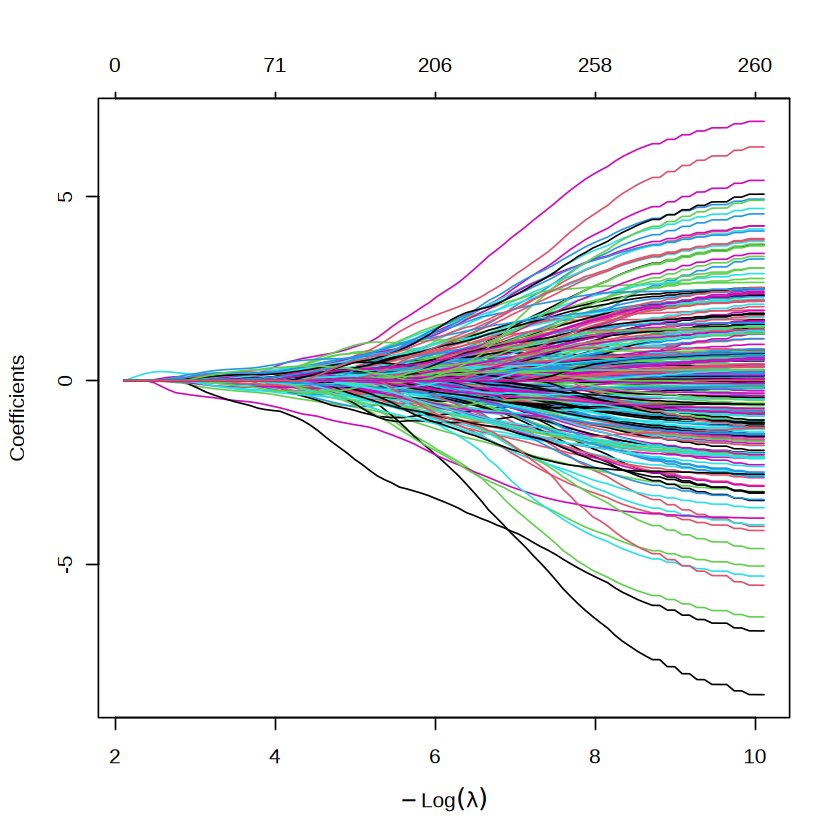

agg_record_1481447857 
                    2

agg_record_1481447857 
                    2

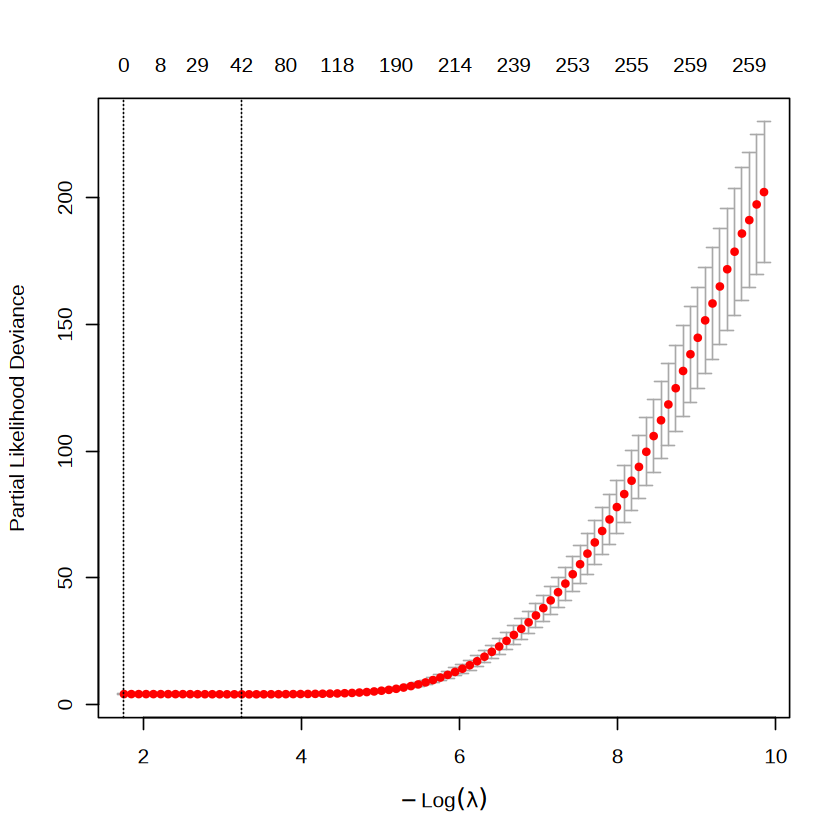

In [5]:
load("/public/hubCache/workshop/sunhy/projects/song_project/project5/Fig2/Model_lasso_cox_数据下载/模型构建/芯片建模_TCGA验证/OKModel_risk.rdata")
load("/public/hubCache/workshop/sunhy/projects/song_project/project5/Fig2/Model_lasso_cox_数据下载/数据整合去批次/CRC_GSE/sc_IRGs.rdata")
dim(train_pd_exp);dim(tset_pd_exp);dim(TCGA_exp_pd)

gene = intersect(colnames(train_pd_exp),sc_IRGs$Gene)

train_pd_exp = train_pd_exp[,c(colnames(train_pd_exp)[1:6],intersect(colnames(train_pd_exp),sc_IRGs$Gene))]

#####单因素Cox#####
uniq_cox  = function(pd_exp,x){
pFilter=0.05  
outTab=data.frame()
sigGenes=c("Status","OS_time")
for(i in colnames(pd_exp[,x:ncol(pd_exp)])){
  cox <- coxph(Surv(OS_time, Status) ~ pd_exp[,i], data = pd_exp)
  coxSummary = summary(cox)
  coxP=coxSummary$coefficients[,"Pr(>|z|)"]
  if(!is.na(coxP)){
      if(coxP<pFilter){
    sigGenes=c(sigGenes,i)
    outTab=rbind(outTab,
                 cbind(id=i,
                       HR=coxSummary$conf.int[,"exp(coef)"],
                       HR.95L=coxSummary$conf.int[,"lower .95"],
                       HR.95H=coxSummary$conf.int[,"upper .95"],
                       pvalue=coxSummary$coefficients[,"Pr(>|z|)"])
    )
  }
  }  
}
    
    return(list(outTab = outTab,uniq_gene = outTab$id))
}

uniq_cox_res = uniq_cox(pd_exp = train_pd_exp,7)

write.csv(uniq_cox_res$outTab,"cox_sig.csv")

y = Surv(train_pd_exp$OS_time,train_pd_exp$Status)
x = as.matrix(train_pd_exp[,uniq_cox_res$uniq_gene])

fit = glmnet(x,y,family = "cox")
plot(fit)
fit.cv = cv.glmnet(x,y,family = "cox",type.measure = "deviance",alpha =  0.7)#0-1
plot(fit.cv)

pdf("lasso_fit.pdf",width = 4,height = 4)
plot(fit,xvar = "lambda")
dev.off()
pdf("lasso_cv.fit.pdf",width = 4,height = 4)
plot(fit.cv)
dev.off()

# Figure 2 k-n

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


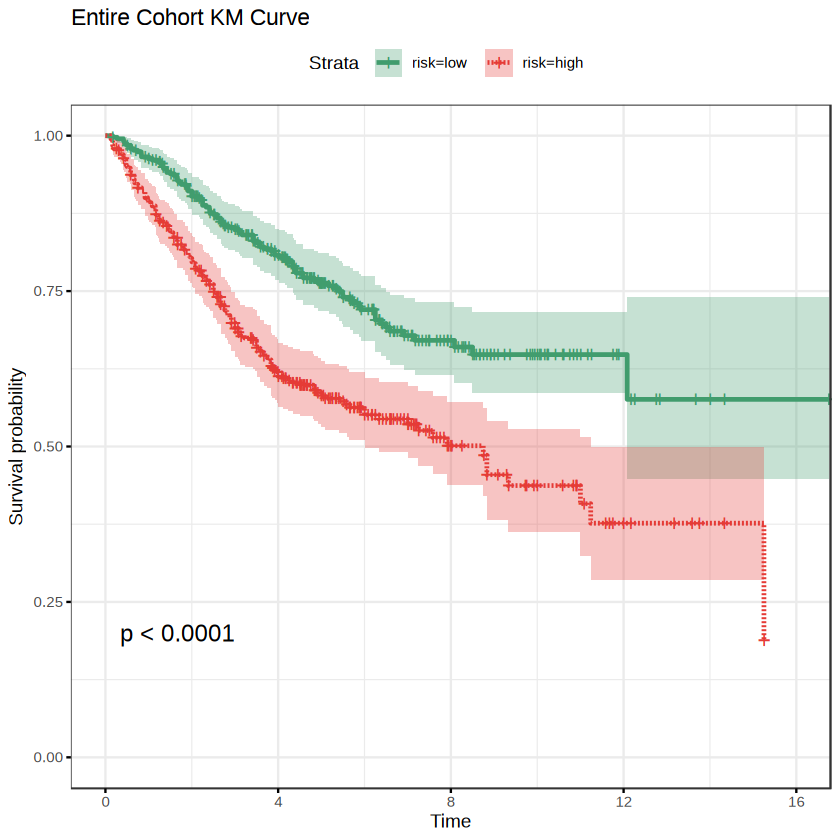

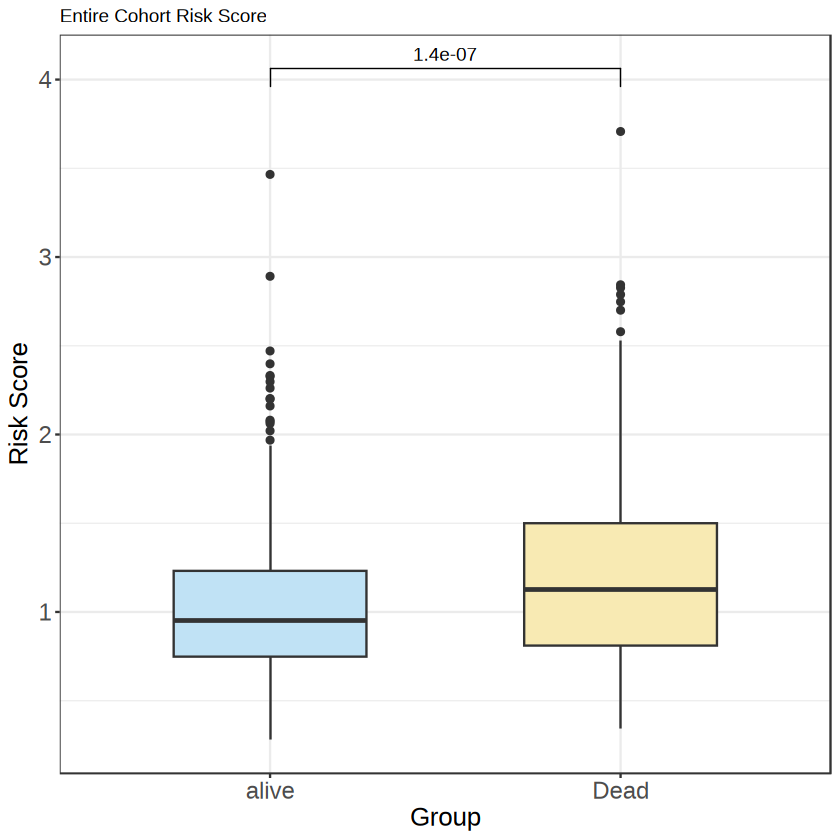

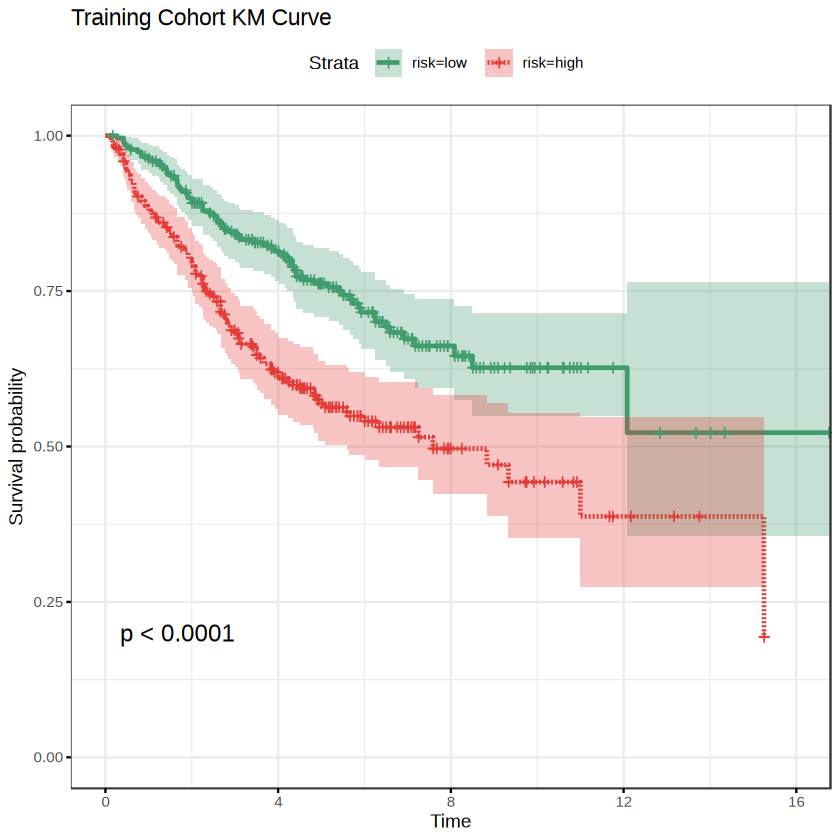

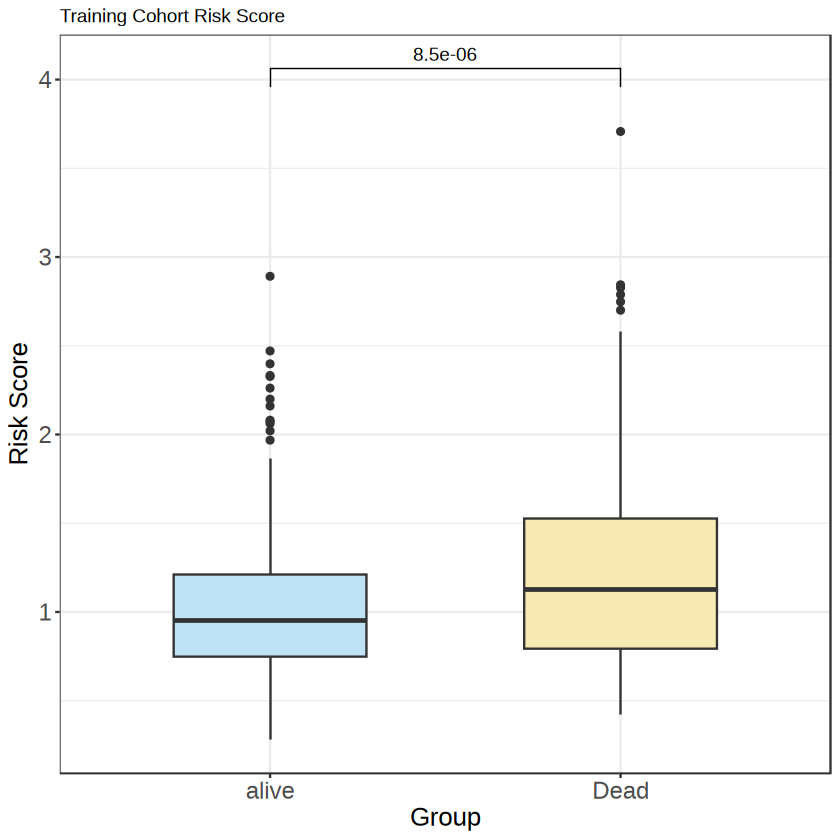

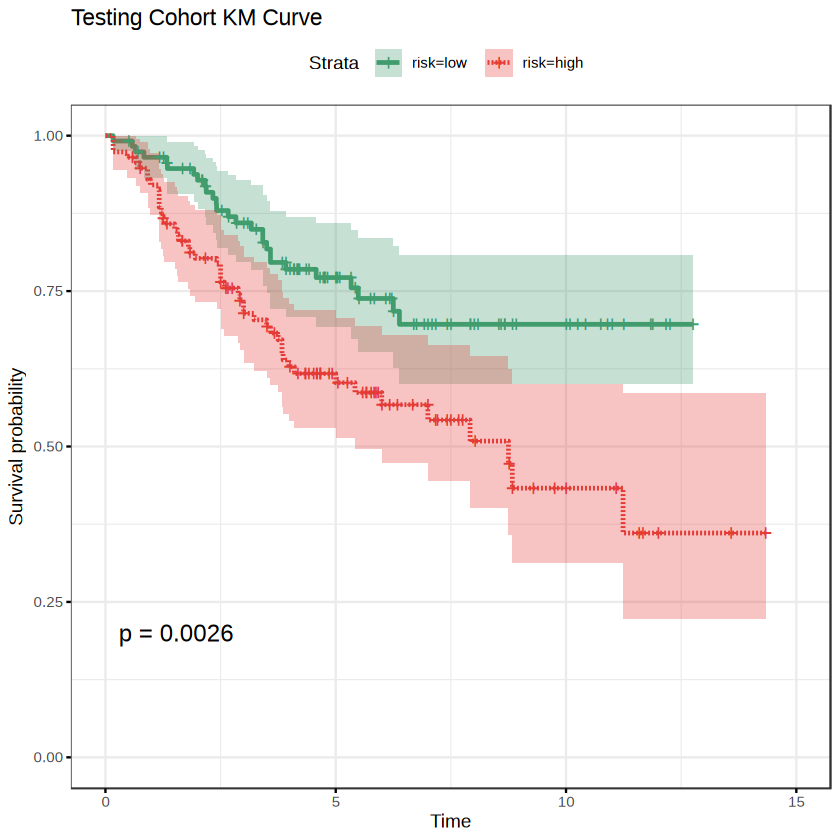

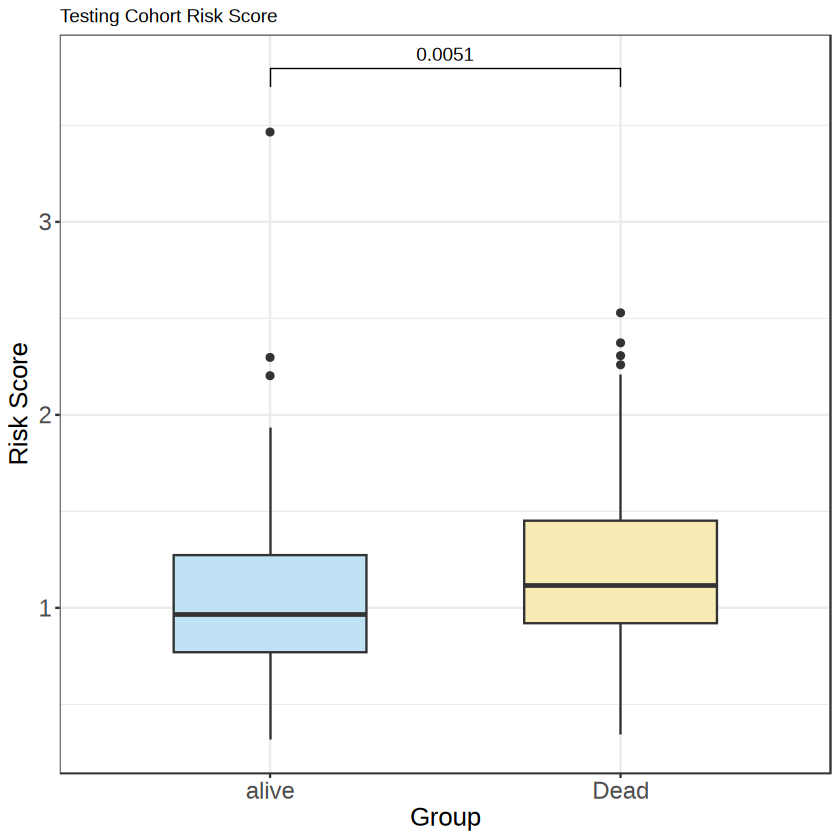

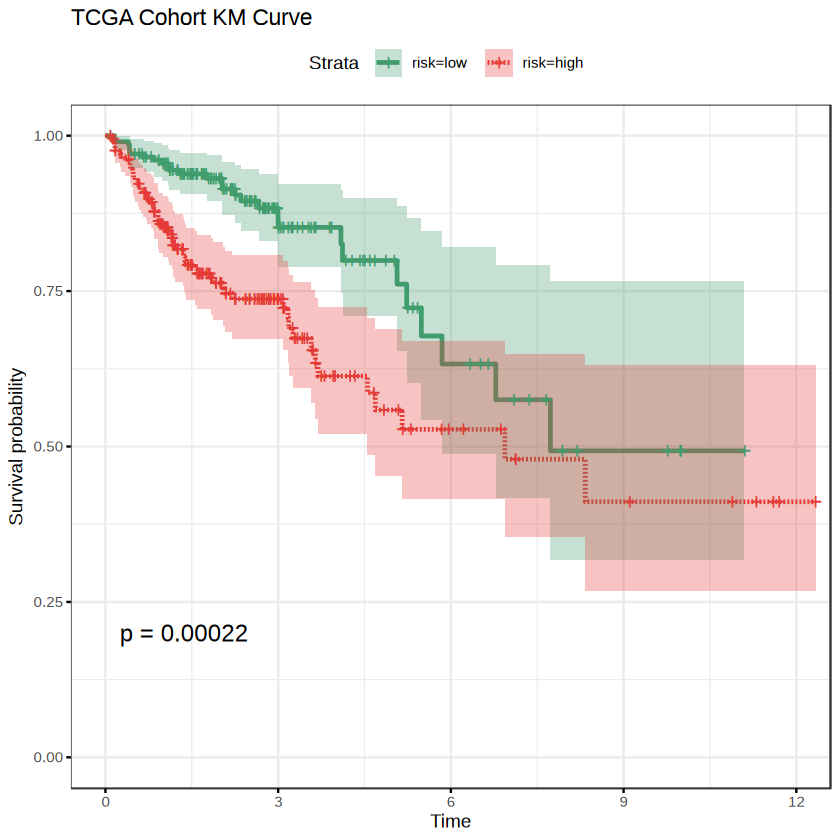

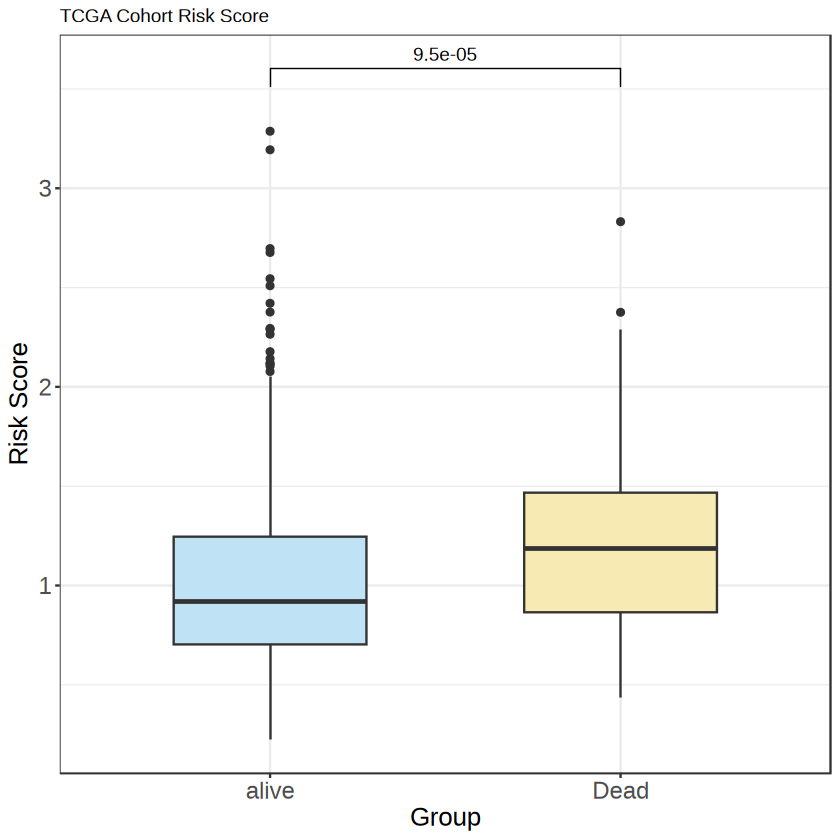

In [6]:
library(survival)
library(survminer)
library(ggplot2)
library(ggpubr)

## ============
## Entire cohort
## ============
entire_risk$risk <- factor(entire_risk$risk, levels = c("low", "high"))
fit_entire <- survfit(Surv(OS_time, Status) ~ risk, data = entire_risk)

print(
  ggsurvplot(
    fit_entire,
    data = entire_risk,
    pval = TRUE, conf.int = TRUE,
    risk.table = FALSE, linetype = "strata",
    ggtheme = theme_bw(),
    palette = c("#419D6E", "#E53B36"),
    title = "Entire Cohort KM Curve"
  )
)

entire_risk$Group <- ifelse(entire_risk$Status == 1, "Dead", "alive")
entire_risk$Group <- factor(entire_risk$Group, levels = c("alive", "Dead"))

print(
  ggplot(entire_risk, aes(x = Group, y = riskScore, fill = Group)) +
    geom_boxplot(width = 0.55, show.legend = FALSE) +
    theme_bw() +
    scale_fill_manual(values = c("#c0e2f5", "#f8eab3")) +
    labs(x = "Group", y = "Risk Score", subtitle = "Entire Cohort Risk Score") +
    stat_compare_means(comparisons = list(c("alive", "Dead")),
                       label.y = max(entire_risk$riskScore) * 1.05) +
    theme(axis.text = element_text(size = 14),
          axis.title = element_text(size = 15))
)

## ============
## Train cohort
## ============
train_risk$risk <- factor(train_risk$risk, levels = c("low", "high"))
fit_train <- survfit(Surv(OS_time, Status) ~ risk, data = train_risk)

print(
  ggsurvplot(
    fit_train,
    data = train_risk,
    pval = TRUE, conf.int = TRUE,
    risk.table = FALSE, linetype = "strata",
    ggtheme = theme_bw(),
    palette = c("#419D6E", "#E53B36"),
    title = "Training Cohort KM Curve"
  )
)

train_risk$Group <- ifelse(train_risk$Status == 1, "Dead", "alive")
train_risk$Group <- factor(train_risk$Group, levels = c("alive", "Dead"))

print(
  ggplot(train_risk, aes(x = Group, y = riskScore, fill = Group)) +
    geom_boxplot(width = 0.55, show.legend = FALSE) +
    theme_bw() +
    scale_fill_manual(values = c("#c0e2f5", "#f8eab3")) +
    labs(x = "Group", y = "Risk Score", subtitle = "Training Cohort Risk Score") +
    stat_compare_means(comparisons = list(c("alive", "Dead")),
                       label.y = max(train_risk$riskScore) * 1.05) +
    theme(axis.text = element_text(size = 14),
          axis.title = element_text(size = 15))
)

## ============
## Test cohort
## ============
test_risk$risk <- factor(test_risk$risk, levels = c("low", "high"))
fit_test <- survfit(Surv(OS_time, Status) ~ risk, data = test_risk)

print(
  ggsurvplot(
    fit_test,
    data = test_risk,
    pval = TRUE, conf.int = TRUE,
    risk.table = FALSE, linetype = "strata",
    ggtheme = theme_bw(),
    palette = c("#419D6E", "#E53B36"),
    title = "Testing Cohort KM Curve"
  )
)

test_risk$Group <- ifelse(test_risk$Status == 1, "Dead", "alive")
test_risk$Group <- factor(test_risk$Group, levels = c("alive", "Dead"))

print(
  ggplot(test_risk, aes(x = Group, y = riskScore, fill = Group)) +
    geom_boxplot(width = 0.55, show.legend = FALSE) +
    theme_bw() +
    scale_fill_manual(values = c("#c0e2f5", "#f8eab3")) +
    labs(x = "Group", y = "Risk Score", subtitle = "Testing Cohort Risk Score") +
    stat_compare_means(comparisons = list(c("alive", "Dead")),
                       label.y = max(test_risk$riskScore) * 1.05) +
    theme(axis.text = element_text(size = 14),
          axis.title = element_text(size = 15))
)

## ============
## TCGA cohort
## ============
TCGA_risk$risk <- factor(TCGA_risk$risk, levels = c("low", "high"))
fit_test <- survfit(Surv(OS_time, Status) ~ risk, data = TCGA_risk)

print(
  ggsurvplot(
    fit_test,
    data = TCGA_risk,
    pval = TRUE, conf.int = TRUE,
    risk.table = FALSE, linetype = "strata",
    ggtheme = theme_bw(),
    palette = c("#419D6E", "#E53B36"),
    title = "TCGA Cohort KM Curve"
  )
)

TCGA_risk$Group <- ifelse(TCGA_risk$Status == 1, "Dead", "alive")
TCGA_risk$Group <- factor(TCGA_risk$Group, levels = c("alive", "Dead"))

print(
  ggplot(TCGA_risk, aes(x = Group, y = riskScore, fill = Group)) +
    geom_boxplot(width = 0.55, show.legend = FALSE) +
    theme_bw() +
    scale_fill_manual(values = c("#c0e2f5", "#f8eab3")) +
    labs(x = "Group", y = "Risk Score", subtitle = "TCGA Cohort Risk Score") +
    stat_compare_means(comparisons = list(c("alive", "Dead")),
                       label.y = max(TCGA_risk$riskScore) * 1.05) +
    theme(axis.text = element_text(size = 14),
          axis.title = element_text(size = 15))
)

